In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# data processing/manipulation
pd.options.mode.chained_assignment = None
import re

# data visualization
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px

# stopwords, tokenizer, stemmer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist

# spell correction, lemmatization
from textblob import TextBlob
from textblob import Word

# sklearn
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')
# Loading each dataset
trump_df = pd.read_csv('/content/drive/My Drive/Creatives/hashtag_donaldtrump.csv', lineterminator='\n')
biden_df = pd.read_csv('/content/drive/My Drive/Creatives/hashtag_joebiden.csv', lineterminator='\n')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Remove unneeded columns
trump_df = trump_df.drop(columns=['tweet_id','user_id','user_name','user_screen_name',
                                  'user_description','user_join_date','collected_at'])
biden_df = biden_df.drop(columns=['tweet_id','user_id','user_name','user_screen_name',
                                  'user_description','user_join_date','collected_at'])

In [ ]:
# Renaming columns
trump_df = trump_df.rename(columns={"likes": "Likes", "retweet_count": "Retweets",
                                    "state": "State", "user_followers_count": "Followers"})
biden_df = biden_df.rename(columns={"likes": "Likes", "retweet_count": "Retweets",
                                    "state": "State", "user_followers_count": "Followers"})

In [ ]:
# Update United States country name for consistency
d = {"United States of America":"United States"}
trump_df['country'].replace(d, inplace=True)
biden_df['country'].replace(d, inplace=True)

<ipython-input-9-195b57dbbdb1>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trump_df['country'].replace(d, inplace=True)
<ipython-input-9-195b57dbbdb1>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [ ]:
trump_df = trump_df.loc[trump_df['country'] == "United States"]
biden_df = biden_df.loc[biden_df['country'] == "United States"]

In [ ]:
# Drop null rows
trump_df = trump_df.dropna()
biden_df = biden_df.dropna()

In [ ]:
import nltk
nltk.download('stopwords')

to_remove = r'\d+|http?\S+|[^A-Za-z0-9]+'
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

# Function to preprocess tweet
def clean_tweet(tweet, stem=False, lemmatize=False):

    # Make all text lowercase
    tweet = tweet.lower()

    # Remove links, special characters, punctuation, numbers, etc.
    tweet = re.sub(to_remove, ' ', tweet)

    filtered_tweet = []
    words = word_tokenize(tweet)

    # Remove stopwords and stem
    for word in words:
        if not word in stop_words:
            if stem:
                filtered_tweet.append(ps.stem(word))
            elif lemmatize:
                filtered_tweet.append(Word(word).lemmatize())
            else:
                filtered_tweet.append(word)

    return filtered_tweet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download('punkt_tab')
# Filtering all trump and biden tweets by applying cleantweet()
trump_df['tweetNew'] = trump_df.tweet.apply(lambda x: clean_tweet(x))
biden_df['tweetNew'] = biden_df.tweet.apply(lambda x: clean_tweet(x))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Looking at 5 trump tweets after filtering
trump_df['tweetNew'].head()

,tweetNew
2,"[trump, student, used, hear, years, ten, years..."
4,"[get, tie, get, tie, trump, rally, iowa]"
11,"[nypost, censorship, censored, twitter, manipu..."
12,"[trump, presidenttrump, trump, landslidevictor..."
22,"[trump, nobody, likes, tell, farmers, better, ..."


In [ ]:
def sentiment_analysis(df):

    # Determine polarity and subjectivity
    df['Polarity'] = df['tweetNew'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
    df['Subjectivity'] = df['tweetNew'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)

    # Classify overall sentiment
    df.loc[df.Polarity > 0,'Sentiment'] = 'positive'
    df.loc[df.Polarity == 0,'Sentiment'] = 'neutral'
    df.loc[df.Polarity < 0,'Sentiment'] = 'negative'

    return df[['tweet','tweetNew','Polarity','Subjectivity','Sentiment']].head()

In [ ]:
# Perform sentiment analysis on trump_df
sentiment_analysis(trump_df)


,tweet,tweetNew,Polarity,Subjectivity,Sentiment
2,"#Trump: As a student I used to hear for years,...","[trump, student, used, hear, years, ten, years...",0.333333,0.333333,positive
4,You get a tie! And you get a tie! #Trump ‘s ra...,"[get, tie, get, tie, trump, rally, iowa]",0.000000,0.000000,neutral
11,"In 2020, #NYPost is being #censorship #CENSORE...","[nypost, censorship, censored, twitter, manipu...",-0.148810,0.678571,negative
12,#Trump #PresidentTrump #Trump2020LandslideVict...,"[trump, presidenttrump, trump, landslidevictor...",0.500000,0.750000,positive
22,"#Trump: Nobody likes to tell you this, but som...","[trump, nobody, likes, tell, farmers, better, ...",0.261905,0.595238,positive


In [ ]:
# Perform sentiment analysis on biden_df
sentiment_analysis(biden_df)

,tweet,tweetNew,Polarity,Subjectivity,Sentiment
6,"In 2020, #NYPost is being #censorship #CENSORE...","[nypost, censorship, censored, twitter, manipu...",-0.148810,0.678571,negative
17,"Comments on this? ""Do Democrats Understand how...","[comments, democrats, understand, ruthless, ch...",-1.000000,1.000000,negative
22,Twitter is doing everything they can to help D...,"[twitter, everything, help, democrats, win, el...",0.175000,0.522222,positive
25,@RealJamesWoods #BidenCrimeFamily #JoeBiden #H...,"[realjameswoods, bidencrimefamily, joebiden, h...",0.000000,0.000000,neutral
29,Come on @ABC PLEASE DO THE RIGHT THING. Move t...,"[come, abc, please, right, thing, move, biden,...",0.078571,0.178571,positive


Trump Tweet Sentiment Breakdown


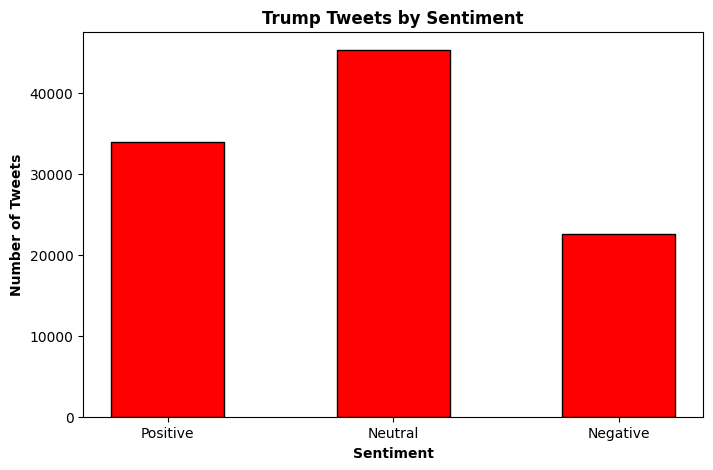

In [ ]:
# Overall sentiment breakdown - Trump
print("Trump Tweet Sentiment Breakdown")

trump_positive = len(trump_df.loc[trump_df.Sentiment=='positive'])
trump_neutral = len(trump_df.loc[trump_df.Sentiment=='neutral'])
trump_negative = len(trump_df.loc[trump_df.Sentiment=='negative'])

# Graphing the number of trump tweets by sentiment
data_t = {'Positive':trump_positive,'Neutral':trump_neutral,'Negative':trump_negative}
sentiment_t = list(data_t.keys())
num_tweets_t = list(data_t.values())

plt.figure(figsize = (8, 5))

plt.bar(sentiment_t, num_tweets_t, color ='red', width = 0.5, edgecolor='black',)

plt.xlabel("Sentiment", fontweight ='bold')
plt.ylabel("Number of Tweets", fontweight ='bold')
plt.title("Trump Tweets by Sentiment", fontweight ='bold')
plt.show()

Biden Tweet Sentiment Breakdown


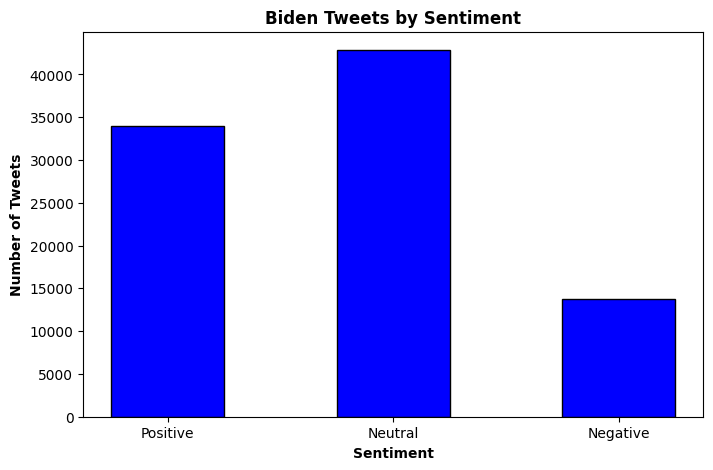

In [ ]:
# Overall sentiment breakdown - Biden
print("Biden Tweet Sentiment Breakdown")

biden_positive = len(biden_df.loc[biden_df.Sentiment=='positive'])
biden_neutral = len(biden_df.loc[biden_df.Sentiment=='neutral'])
biden_negative = len(biden_df.loc[biden_df.Sentiment=='negative'])

# Graphing the number of biden tweets by sentiment
data_b = {'Positive':biden_positive,'Neutral':biden_neutral,'Negative':biden_negative}
sentiment_b = list(data_b.keys())
num_tweets_b = list(data_b.values())

plt.figure(figsize = (8, 5))

plt.bar(sentiment_b, num_tweets_b, color ='blue', width = 0.5, edgecolor='black')

plt.xlabel("Sentiment", fontweight ='bold')
plt.ylabel("Number of Tweets", fontweight ='bold')
plt.title("Biden Tweets by Sentiment", fontweight ='bold')
plt.show()

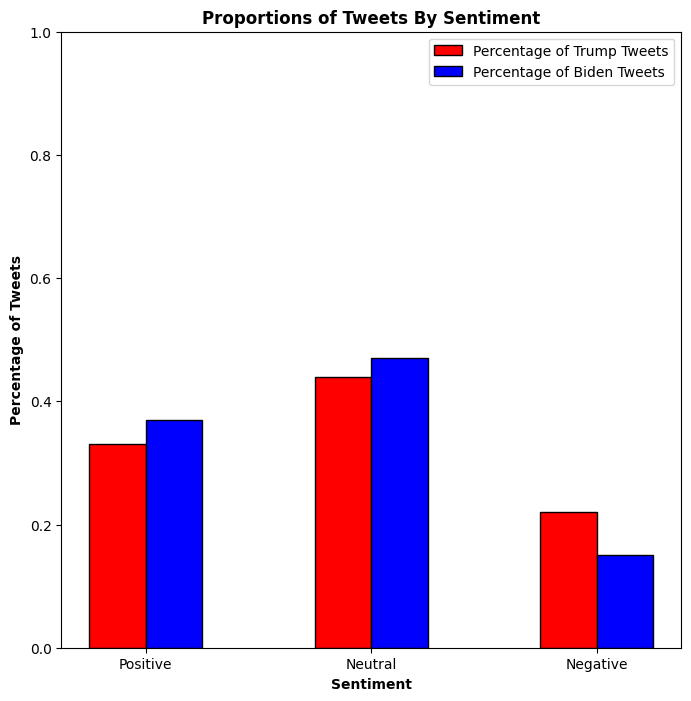

In [ ]:
# Calculate relative percentages by sentiment - Trump
total_tweets_t = len(trump_df.Sentiment)
prop_tweets_t = list(map(lambda x: round(x/total_tweets_t,2), num_tweets_t))

# Calculate relative percentages by sentiment - Biden
total_tweets_b = len(biden_df.Sentiment)
prop_tweets_b = list(map(lambda x: round(x/total_tweets_b,2), num_tweets_b))

# Graphing relative percentages of both trump and biden tweets
bar_width = 0.25
plt.subplots(figsize=(8,8))

br1 = np.arange(3)
br2 = [x + bar_width for x in br1]

t = plt.bar(br1, prop_tweets_t, color ='r', width = bar_width,
            edgecolor ='black', label ='Trump')
b = plt.bar(br2, prop_tweets_b, color ='b', width = bar_width,
            edgecolor ='black', label ='Biden')

plt.xlabel('Sentiment',fontweight ='bold')
plt.ylabel('Percentage of Tweets',fontweight ='bold')
plt.xticks([r + bar_width/2 for r in range(3)],['Positive','Neutral','Negative'])
plt.legend([t,b],['Percentage of Trump Tweets','Percentage of Biden Tweets'])
plt.ylim(0.0, 1.0)
plt.title('Proportions of Tweets By Sentiment',fontweight ='bold')

plt.show()

In [ ]:
# Function to return a string of all words in all tweets
def get_all_tweets(df,by_sentiment=False,sentiment="positive"):
    words = ' '.join(df['tweetNew'].apply(lambda x: ' '.join(x)))
    return words

In [ ]:
# Create word strings
words_trump = get_all_tweets(trump_df)
words_biden = get_all_tweets(biden_df)

# Tokenize word strings
tokens_trump = word_tokenize(words_trump)
tokens_biden = word_tokenize(words_biden)

# Function to generate word cloud
def create_wordcloud(words):

    # create wordcloud
    wordcloud = WordCloud(max_font_size=200, max_words=200,
                          background_color="white").generate(words)

    # display the generated image
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
# Ensure 'Polarity' column is numeric, coerce errors to NaN and drop them
trump_df["Polarity"] = pd.to_numeric(trump_df["Polarity"], errors='coerce')

# Drop rows where 'Polarity' is NaN if any, to avoid mean calculation issues
trump_df = trump_df.dropna(subset=["Polarity"])

# Group by state and calculate the mean polarity
trump_state_polarity = trump_df.groupby("State", as_index=False)["Polarity"].mean()

# Plotting
fig = px.bar(trump_state_polarity, x="State", y="Polarity",
             title="<b>Average Polarity of Trump-Related Tweets by State</b>")
fig.update_traces(marker=dict(color="red"), selector=dict(type="bar"),
                  marker_line_color='black', marker_line_width=0.8, opacity=0.6)
fig.show()

In [ ]:
# Ensure 'Polarity' column is numeric, coerce errors to NaN and drop them
biden_df["Polarity"] = pd.to_numeric(biden_df["Polarity"], errors='coerce')

# Drop rows where 'Polarity' is NaN if any, to avoid mean calculation issues
biden_df = biden_df.dropna(subset=["Polarity"])

# Group by state and calculate the mean polarity
biden_state_polarity = biden_df.groupby("State", as_index=False)["Polarity"].mean()

# Plotting
fig = px.bar(biden_state_polarity, x="State", y="Polarity",
             title="<b>Average Polarity of Trump-Related Tweets by State</b>")
fig.update_traces(marker=dict(color="blue"), selector=dict(type="bar"),
                  marker_line_color='black', marker_line_width=0.8, opacity=0.6)
fig.show()

In [ ]:
print(trump_df.columns)
print(biden_df.columns)


Index(['created_at', 'tweet', 'Likes', 'Retweets', 'source', 'Followers',
       'user_location', 'lat', 'long', 'city', 'country', 'continent', 'State',
       'state_code', 'tweetNew', 'Polarity', 'Subjectivity', 'Sentiment'],
      dtype='object')
Index(['created_at', 'tweet', 'Likes', 'Retweets', 'source', 'Followers',
       'user_location', 'lat', 'long', 'city', 'country', 'continent', 'State',
       'state_code', 'tweetNew', 'Polarity', 'Subjectivity', 'Sentiment'],
      dtype='object')


In [ ]:
trump_df['tweet_date'] = pd.to_datetime(trump_df['created_at'])
biden_df['tweet_date'] = pd.to_datetime(biden_df['created_at'])


In [ ]:
from textblob import TextBlob
import pandas as pd

# Convert 'tweet_date' to datetime
trump_df['tweet_date'] = pd.to_datetime(trump_df['tweet_date'])
biden_df['tweet_date'] = pd.to_datetime(biden_df['tweet_date'])

# Define time periods for Trump
trump_pre = trump_df[trump_df['tweet_date'] <= '2020-11-02']
trump_voting = trump_df[(trump_df['tweet_date'] >= '2020-11-03') & (trump_df['tweet_date'] <= '2020-11-07')]
trump_post = trump_df[trump_df['tweet_date'] >= '2020-11-08']

# Define time periods for Biden
biden_pre = biden_df[biden_df['tweet_date'] <= '2020-11-02']
biden_voting = biden_df[(biden_df['tweet_date'] >= '2020-11-03') & (biden_df['tweet_date'] <= '2020-11-07')]
biden_post = biden_df[biden_df['tweet_date'] >= '2020-11-08']

# Debugging: Print the number of rows in each period for confirmation
print(f"Trump pre-voting period: {len(trump_pre)} rows")
print(f"Trump voting period: {len(trump_voting)} rows")
print(f"Trump post-election period: {len(trump_post)} rows")

print(f"Biden pre-voting period: {len(biden_pre)} rows")
print(f"Biden voting period: {len(biden_voting)} rows")
print(f"Biden post-election period: {len(biden_post)} rows")


Trump pre-voting period: 59257 rows
Trump voting period: 25407 rows
Trump post-election period: 4876 rows
Biden pre-voting period: 45475 rows
Biden voting period: 21022 rows
Biden post-election period: 7151 rows


In [ ]:
def sentiment_analysis(df):

    # Determine polarity and subjectivity
    df['Polarity'] = df['tweetNew'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
    df['Subjectivity'] = df['tweetNew'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)

    # Classify overall sentiment
    df.loc[df.Polarity > 0,'Sentiment'] = 'positive'
    df.loc[df.Polarity == 0,'Sentiment'] = 'neutral'
    df.loc[df.Polarity < 0,'Sentiment'] = 'negative'

    return df[['tweet','tweetNew','Polarity','Subjectivity','Sentiment']].head(1)

# Perform sentiment analysis on trump_df
sentiment_analysis(trump_pre)
sentiment_analysis(trump_voting)
sentiment_analysis(trump_post)
sentiment_analysis(biden_pre)
sentiment_analysis(biden_voting)
sentiment_analysis(biden_post)


,tweet,tweetNew,Polarity,Subjectivity,Sentiment
701314,RIFF editors: #JoeBiden has finally won #Presi...,"[riff, editors, joebiden, finally, presidentia...",0.0,0.5,neutral


In [ ]:
import matplotlib.pyplot as plt

def plot_sentiment(df, name):
    """
    This function calculates the number of tweets by sentiment and creates a bar plot.
    Displays percentages for each sentiment category out of 100.

    Parameters:
    df (DataFrame): The DataFrame containing tweet sentiment data.
    name (str): A descriptive name for the DataFrame (e.g., "Trump Tweets").
    """
    # Calculate the number of tweets for each sentiment
    positive = len(df.loc[df.Sentiment == 'positive'])
    neutral = len(df.loc[df.Sentiment == 'neutral'])
    negative = len(df.loc[df.Sentiment == 'negative'])

    # Total tweets
    total = positive + neutral + negative

    # Calculate percentages
    positive_pct = (positive / total) * 100
    neutral_pct = (neutral / total) * 100
    negative_pct = (negative / total) * 100

    # Create data for plotting
    data = {'Positive': positive, 'Neutral': neutral, 'Negative': negative}
    percentages = [positive_pct, neutral_pct, negative_pct]
    sentiment = list(data.keys())
    num_tweets = list(data.values())

    # Plot the bar graph
    plt.figure(figsize=(10, 6))
    bars = plt.bar(sentiment, num_tweets, color=['green', 'blue', 'red'], width=0.5, edgecolor='black')

    # Add percentages above bars
    for bar, pct in zip(bars, percentages):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{pct:.1f}%',
                 ha='center', fontsize=10, fontweight='bold')

    plt.xlabel("Sentiment", fontweight='bold')
    plt.ylabel("Number of Tweets", fontweight='bold')
    plt.title(f"Sentiment Analysis of {name}", fontweight='bold')
    plt.show()


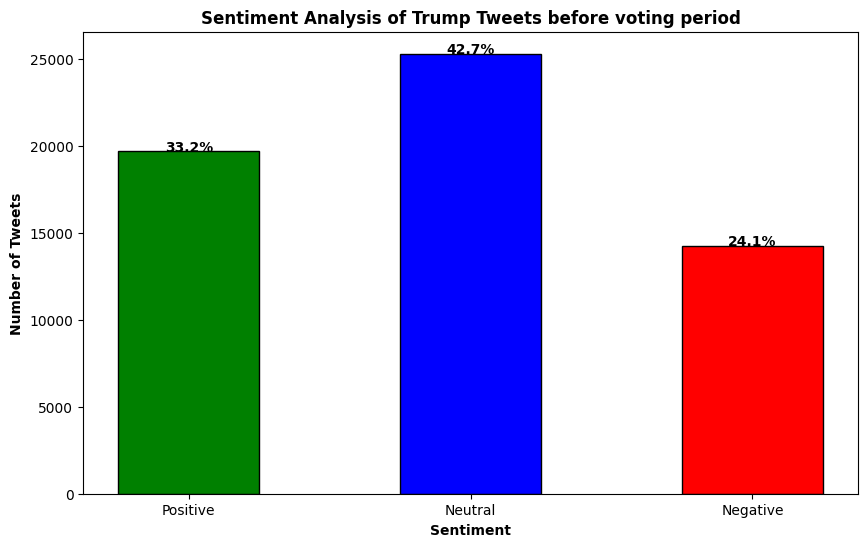

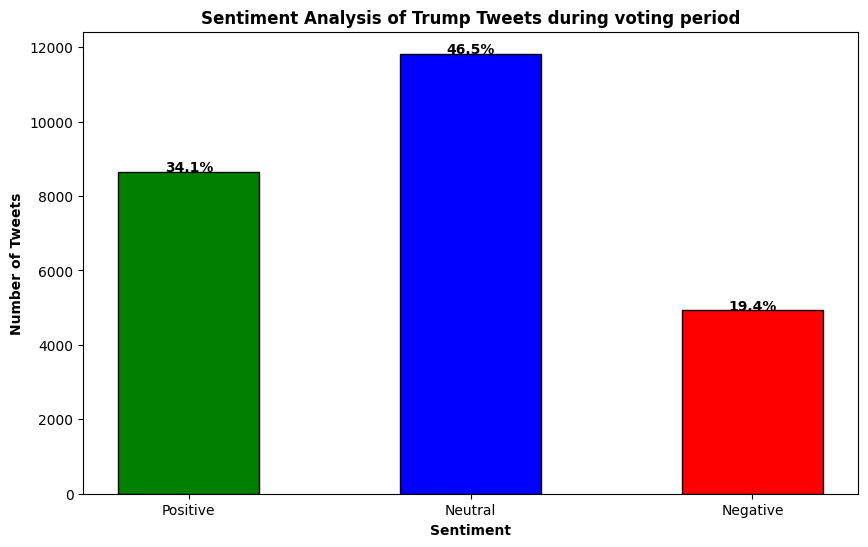

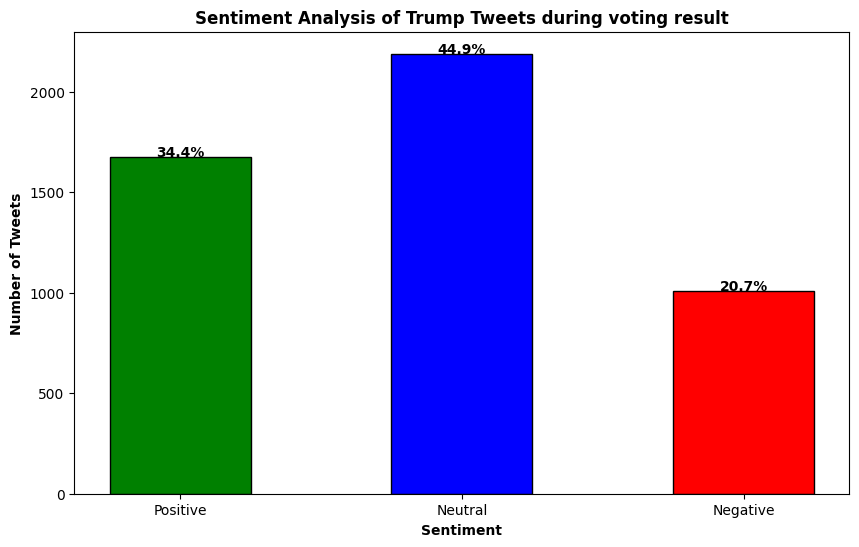

In [ ]:
# Example usage
plot_sentiment(trump_pre, "Trump Tweets before voting period")
plot_sentiment(trump_voting, "Trump Tweets during voting period")
plot_sentiment(trump_post, "Trump Tweets during voting result")


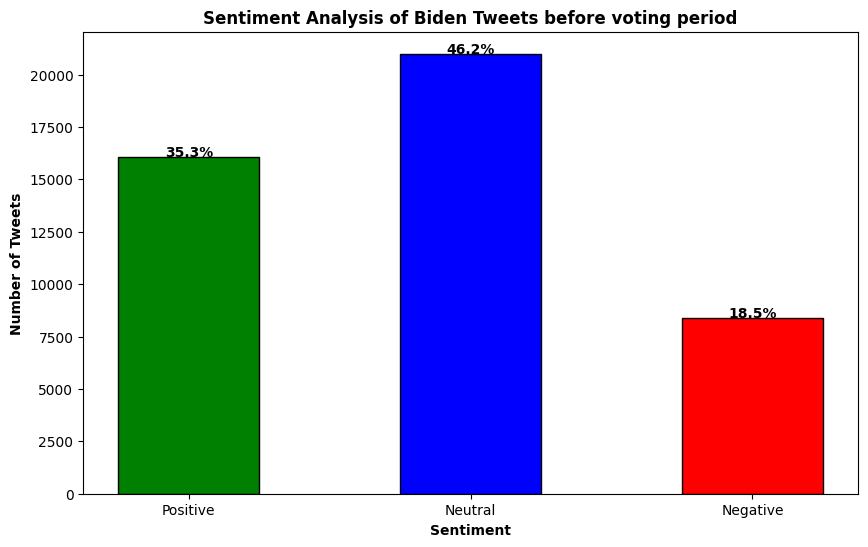

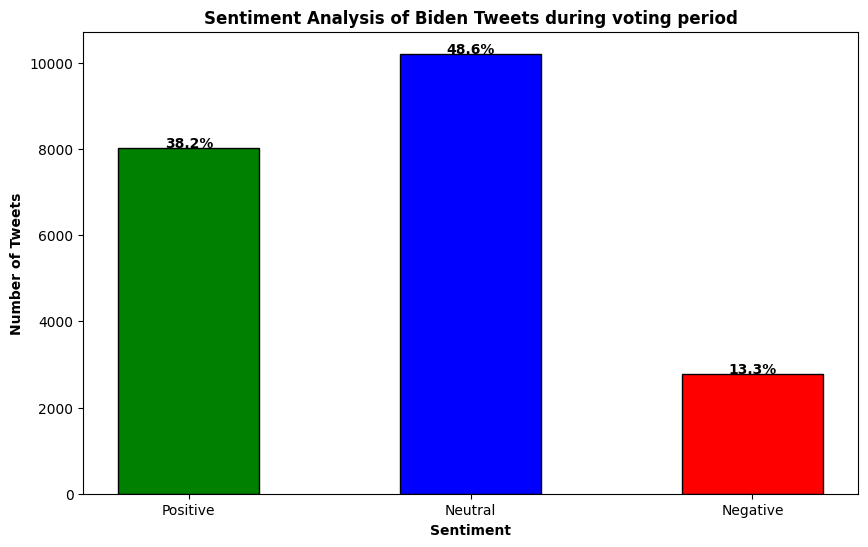

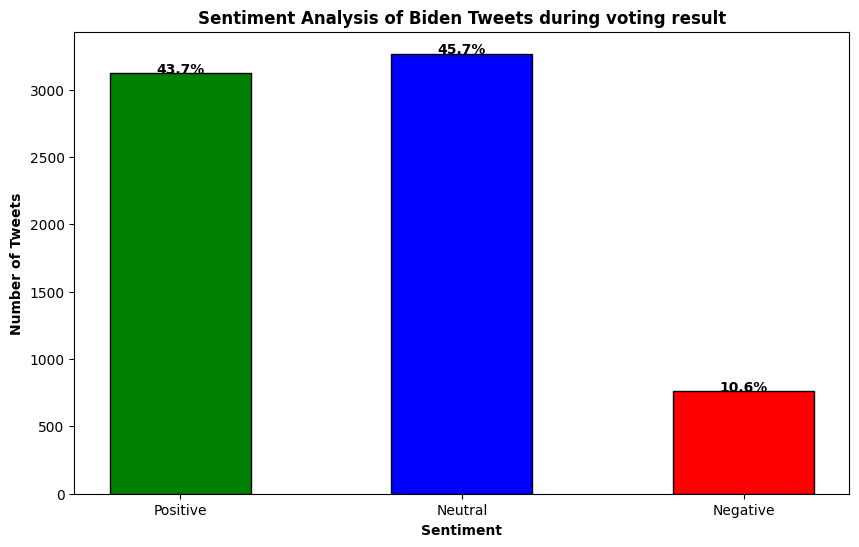

In [ ]:
# Example usage
plot_sentiment(biden_pre, "Biden Tweets before voting period")
plot_sentiment(biden_voting, "Biden Tweets during voting period")
plot_sentiment(biden_post, "Biden Tweets during voting result")


Biden post-election period (A): 1675 rows


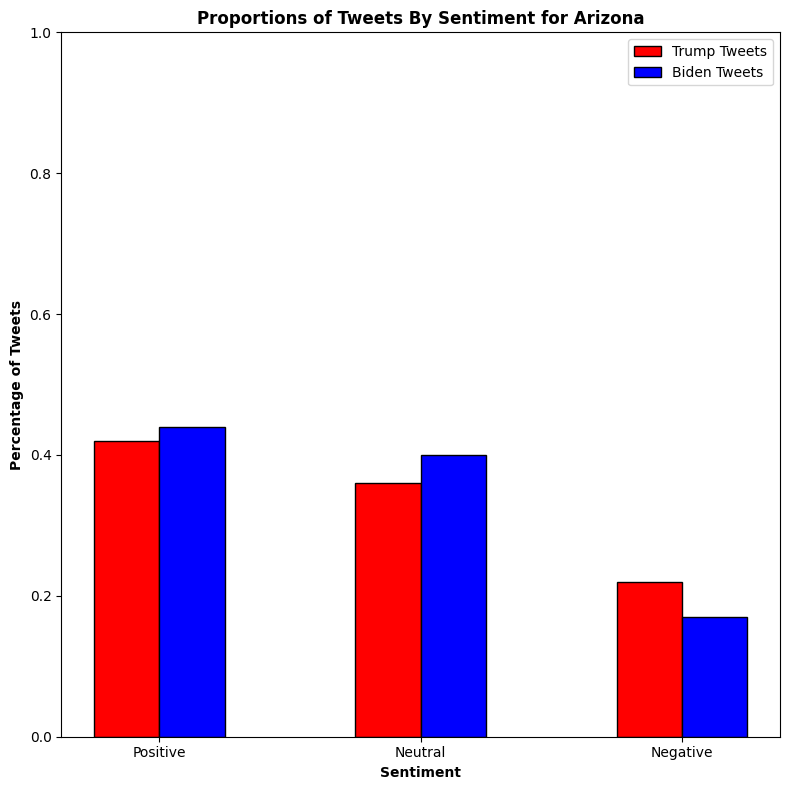

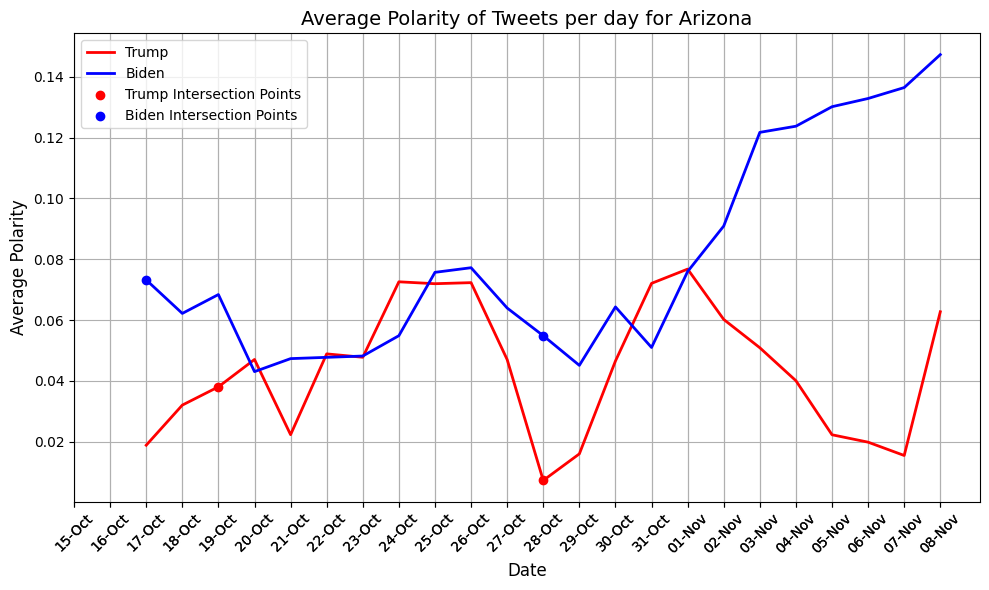

In [ ]:
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt


# Convert 'tweet_date' to datetime
trump_df['tweet_date'] = pd.to_datetime(trump_df['tweet_date'])
biden_df['tweet_date'] = pd.to_datetime(biden_df['tweet_date'])

# Filter data for Alaska
trump_arizona = trump_df[trump_df['State'] == 'Arizona']
biden_arizona = biden_df[biden_df['State'] == 'Arizona']

print(f"Biden post-election period (A): {len(trump_arizona)} rows")

sentiment_analysis(trump_arizona)
#plot_sentiment(trump_arizona, "Sentiment of Arizona for Trump")

sentiment_analysis(biden_arizona)
#plot_sentiment(biden_arizona, "Sentiment of Arizona for Biden")

# Calculate relative percentages by sentiment for Trump
total_tweets_t = len(trump_arizona)  # Total number of Trump tweets
num_tweets_t = trump_arizona['Sentiment'].value_counts()  # Count of each sentiment type (positive, neutral, negative)
prop_tweets_t = list(map(lambda x: round(x / total_tweets_t, 2), num_tweets_t))  # Proportions of sentiments

# Calculate relative percentages by sentiment for Biden
total_tweets_b = len(biden_arizona)  # Total number of Biden tweets
num_tweets_b = biden_arizona['Sentiment'].value_counts()  # Count of each sentiment type (positive, neutral, negative)
prop_tweets_b = list(map(lambda x: round(x / total_tweets_b, 2), num_tweets_b))  # Proportions of sentiments

# Graphing relative percentages of both Trump and Biden tweets
bar_width = 0.25
plt.subplots(figsize=(8, 8))

# Bar positions for Trump and Biden
br1 = np.arange(3)  # Positions for Trump's bars
br2 = [x + bar_width for x in br1]  # Positions for Biden's bars

# Plotting Trump's bars (Red)
t = plt.bar(br1, prop_tweets_t, color='r', width=bar_width, edgecolor='black', label='Trump')

# Plotting Biden's bars (Blue)
b = plt.bar(br2, prop_tweets_b, color='b', width=bar_width, edgecolor='black', label='Biden')

# Customizing the chart
plt.xlabel('Sentiment', fontweight='bold')
plt.ylabel('Percentage of Tweets', fontweight='bold')
plt.xticks([r + bar_width / 2 for r in range(3)], ['Positive', 'Neutral', 'Negative'])
plt.legend([t, b], ['Trump Tweets', 'Biden Tweets'])
plt.ylim(0.0, 1.0)  # Y-axis range to 0 to 1 (100%)
plt.title('Proportions of Tweets By Sentiment for Arizona', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()


# Assuming you already have the 'tweet_date' and 'Polarity' columns in both datasets
# Make sure the 'tweet_date' column is datetime
trump_arizona['tweet_date'] = pd.to_datetime(trump_arizona['tweet_date'])
biden_arizona['tweet_date'] = pd.to_datetime(biden_arizona['tweet_date'])

# Combine both datasets (Trump in red, Biden in blue)
df = pd.concat([trump_arizona[['tweet_date', 'Polarity']].assign(Candidate='Trump'),
                biden_arizona[['tweet_date', 'Polarity']].assign(Candidate='Biden')])

# Group by date and calculate the average polarity for each day
daily_avg_polarity = df.groupby([df['tweet_date'].dt.date, 'Candidate'])['Polarity'].mean().reset_index()

# Convert the date into a datetime object for plotting
daily_avg_polarity['tweet_date'] = pd.to_datetime(daily_avg_polarity['tweet_date'])

# Smooth the line using a rolling mean (window of 3 days, adjust as needed)
daily_avg_polarity['smoothed_polarity'] = daily_avg_polarity.groupby('Candidate')['Polarity'].transform(lambda x: x.rolling(window=3).mean())

# Plot the time series graph
plt.figure(figsize=(10, 6))

# Plot Trump's data (Red)
trump_data = daily_avg_polarity[daily_avg_polarity['Candidate'] == 'Trump']
plt.plot(trump_data['tweet_date'], trump_data['smoothed_polarity'], label='Trump', color='red', linewidth=2)

# Plot Biden's data (Blue)
biden_data = daily_avg_polarity[daily_avg_polarity['Candidate'] == 'Biden']
plt.plot(biden_data['tweet_date'], biden_data['smoothed_polarity'], label='Biden', color='blue', linewidth=2)

# Mark the intersection points (specific dates)
oct_19 = pd.to_datetime("2020-10-19")
oct_28 = pd.to_datetime("2020-10-28")
oct_15 = pd.to_datetime("2020-10-17")

# Intersection points for Trump
trump_intersection = trump_data[trump_data['tweet_date'].isin([oct_19, oct_28])]

# Intersection points for Biden
biden_intersection = biden_data[biden_data['tweet_date'].isin([oct_15, oct_28])]

# Plot intersection points for Trump (red) and Biden (blue)
plt.scatter(trump_intersection['tweet_date'], trump_intersection['smoothed_polarity'], color='red', zorder=5, label='Trump Intersection Points')
plt.scatter(biden_intersection['tweet_date'], biden_intersection['smoothed_polarity'], color='blue', zorder=5, label='Biden Intersection Points')

# Customize plot
plt.title('Average Polarity of Tweets per day for Arizona', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Polarity', fontsize=12)
plt.xticks(daily_avg_polarity['tweet_date'], daily_avg_polarity['tweet_date'].dt.strftime('%d-%b'), rotation=45)
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from textblob import TextBlob

def sentiment_analysis_statewise(df):
    # Determine polarity and subjectivity
    df['Polarity'] = df['tweetNew'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)
    df['Subjectivity'] = df['tweetNew'].apply(lambda x: TextBlob(' '.join(x)).sentiment.subjectivity)

    # Classify overall sentiment
    df.loc[df.Polarity > 0, 'Sentiment'] = 'positive'
    df.loc[df.Polarity == 0, 'Sentiment'] = 'neutral'
    df.loc[df.Polarity < 0, 'Sentiment'] = 'negative'

    # Calculate state-wise sentiment analysis percentages
    sentiment_counts = df.groupby('State')['Sentiment'].value_counts(normalize=True).unstack(fill_value=0) * 100

    # Print the percentage of each sentiment by state
    print("State-wise Sentiment Analysis Percentage:")
    print(sentiment_counts)


In [ ]:
sentiment_analysis_statewise(trump_df)

State-wise Sentiment Analysis Percentage:
Sentiment              negative    neutral   positive
State                                                
Alabama               24.367089  37.025316  38.607595
Alaska                20.430108  50.537634  29.032258
Arizona               22.149254  41.671642  36.179104
Arkansas              24.285714  51.428571  24.285714
California            21.957174  46.137023  31.905803
Colorado              25.030012  42.436975  32.533013
Connecticut           21.538462  42.051282  36.410256
Delaware               6.666667  80.000000  13.333333
District of Columbia  20.061175  47.959076  31.979749
Florida               17.859187  52.175157  29.965655
Georgia               17.839196  45.979899  36.180905
Hawaii                25.750000  44.250000  30.000000
Idaho                 27.129338  33.123028  39.747634
Illinois              25.286663  41.500704  33.212633
Indiana               20.857474  57.473928  21.668598
Iowa                  23.668639  46.7455

In [ ]:
sentiment_analysis_statewise(biden_df)

State-wise Sentiment Analysis Percentage:
Sentiment              negative    neutral   positive
State                                                
Alabama               15.358362  48.464164  36.177474
Alaska                15.079365  38.888889  46.031746
Arizona               16.621548  43.692474  39.685977
Arkansas              17.333333  33.333333  49.333333
California            15.393759  46.050520  38.555721
Colorado              16.144201  50.313480  33.542320
Connecticut           17.218543  50.331126  32.450331
Delaware               5.747126  40.229885  54.022989
District of Columbia  13.470613  51.623052  34.906335
Florida               12.997940  53.021978  33.980082
Georgia               13.724008  47.410208  38.865784
Hawaii                18.483412  42.180095  39.336493
Idaho                 20.000000  44.848485  35.151515
Illinois              15.813702  46.709992  37.476307
Indiana               11.926606  62.232416  25.840979
Iowa                  12.857143  45.0000

Analyzing sentiment for Trump...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqbgy_xqr/4hfwzbvt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqbgy_xqr/o7d60646.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44269', 'data', 'file=/tmp/tmpqbgy_xqr/4hfwzbvt.json', 'init=/tmp/tmpqbgy_xqr/o7d60646.json', 'output', 'file=/tmp/tmpqbgy_xqr/prophet_modelw0f1gj75/prophet_model-20241118033359.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:33:59 - cmdstanpy - INFO - Chain [1] start processing
IN

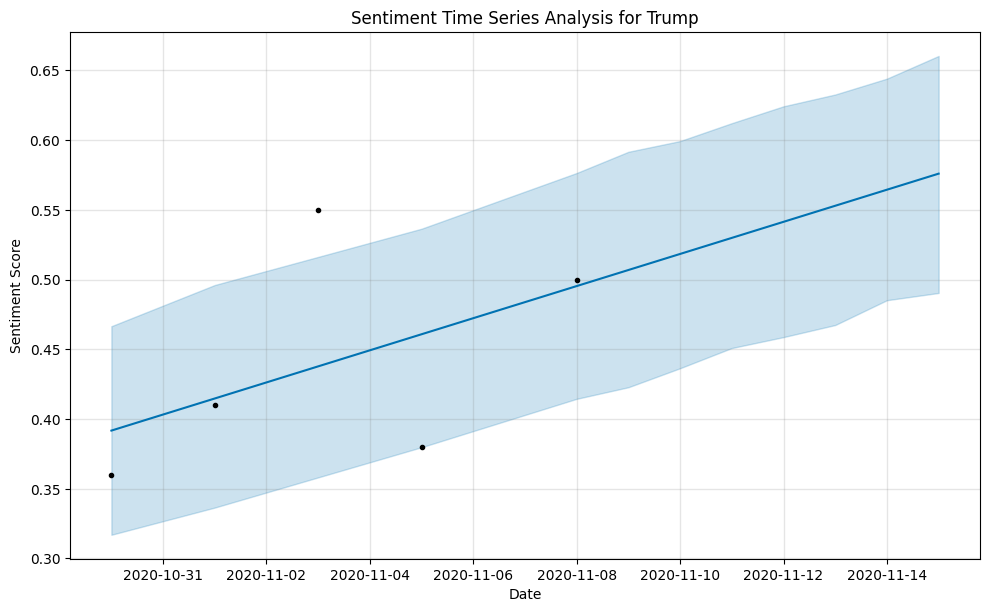

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqbgy_xqr/u7t96aki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqbgy_xqr/hr8hm8vt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69843', 'data', 'file=/tmp/tmpqbgy_xqr/u7t96aki.json', 'init=/tmp/tmpqbgy_xqr/hr8hm8vt.json', 'output', 'file=/tmp/tmpqbgy_xqr/prophet_modelq4dlepxt/prophet_model-20241118033400.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:34:00 - cmdstanpy - INFO - Chain [1] start processing
IN

Analyzing sentiment for Biden...


03:34:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


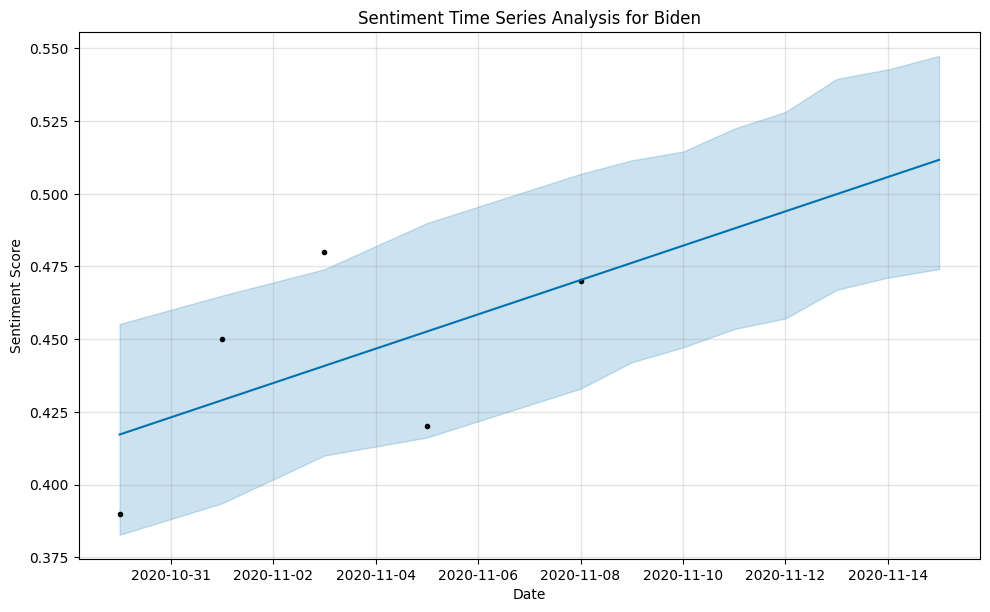

In [ ]:
from textblob import TextBlob
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Sample hardcoded data for demonstration purposes
data = {
    'tweet_date': [
        '2020-10-30', '2020-11-01', '2020-11-03', '2020-11-05', '2020-11-08',
        '2020-10-30', '2020-11-01', '2020-11-03', '2020-11-05', '2020-11-08'
    ],
    'sentiment': [0.36, 0.41, 0.55, 0.38, 0.50, 0.39, 0.45, 0.48, 0.42, 0.47],
    'state': ['Alaska'] * 10,
    'candidate': ['Trump'] * 5 + ['Biden'] * 5
}

# Create DataFrame
df = pd.DataFrame(data)
df['tweet_date'] = pd.to_datetime(df['tweet_date'])

# Filter data for Alaska and split by candidate
trump_df = df[(df['state'] == 'Alaska') & (df['candidate'] == 'Trump')]
biden_df = df[(df['state'] == 'Alaska') & (df['candidate'] == 'Biden')]

# Define a function to prepare data for Prophet and plot
def analyze_sentiment_with_prophet(data, candidate_name):
    # Prepare data for Prophet
    df_prophet = data[['tweet_date', 'sentiment']].rename(columns={'tweet_date': 'ds', 'sentiment': 'y'})

    # Instantiate and fit the model
    model = Prophet()
    model.fit(df_prophet)

    # Make a future DataFrame for predictions
    future = model.make_future_dataframe(periods=7)  # Add 7 days for forecasting
    forecast = model.predict(future)

    # Plot results
    fig = model.plot(forecast)
    plt.title(f"Sentiment Time Series Analysis for {candidate_name}")
    plt.xlabel("Date")
    plt.ylabel("Sentiment Score")
    plt.show()

    # Optional: Return the forecasted data
    return forecast

# Analyze for Trump
print("Analyzing sentiment for Trump...")
forecast_trump = analyze_sentiment_with_prophet(trump_df, "Trump")

# Analyze for Biden
print("Analyzing sentiment for Biden...")
forecast_biden = analyze_sentiment_with_prophet(biden_df, "Biden")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqbgy_xqr/0i0kek_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqbgy_xqr/0wkv351g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6182', 'data', 'file=/tmp/tmpqbgy_xqr/0i0kek_n.json', 'init=/tmp/tmpqbgy_xqr/0wkv351g.json', 'output', 'file=/tmp/tmpqbgy_xqr/prophet_modelvgb_9ikx/prophet_model-20241118033402.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:34:02 - cmdstanpy - INFO - Chain [1] start processing
INF

Trump Sentiment Analysis


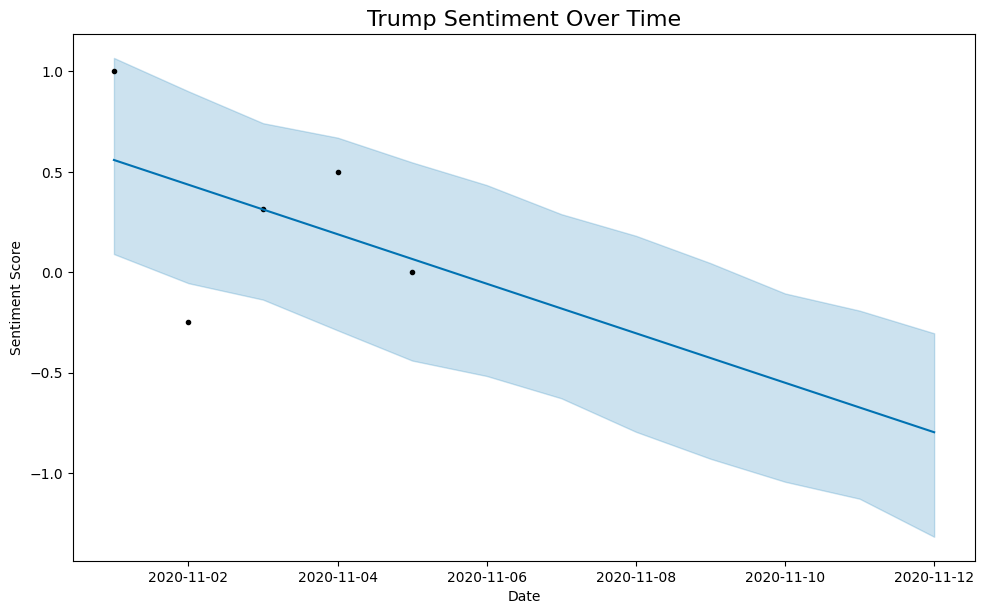

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqbgy_xqr/4c7dq4h2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqbgy_xqr/uq4__7y_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72042', 'data', 'file=/tmp/tmpqbgy_xqr/4c7dq4h2.json', 'init=/tmp/tmpqbgy_xqr/uq4__7y_.json', 'output', 'file=/tmp/tmpqbgy_xqr/prophet_modellzjlkonr/prophet_model-20241118033402.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:34:02 - cmdstanpy - INFO - Chain [1] start processing
IN

Biden Sentiment Analysis


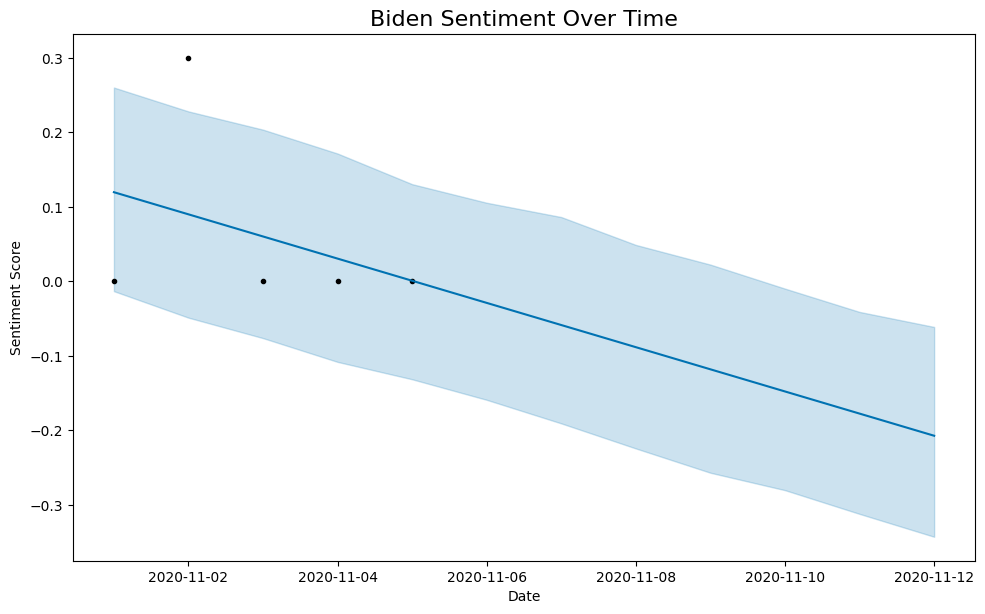

In [ ]:
from textblob import TextBlob
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Example hardcoded Trump and Biden data (replace with your actual dataset)
data_trump = {
    'tweet_date': ['2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05'],
    'tweet_text': [
        "Trump is great!",
        "Not sure about Trump today.",
        "I love the policies Trump offers!",
        "The speech today was okay.",
        "What is happening with Trump?"
    ]
}

data_biden = {
    'tweet_date': ['2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05'],
    'tweet_text': [
        "Biden has my vote!",
        "Biden's plans sound promising.",
        "The campaign was solid!",
        "Biden is alright, I guess.",
        "Biden's ideas seem futuristic."
    ]
}

# Load data into DataFrames
trump_df = pd.DataFrame(data_trump)
biden_df = pd.DataFrame(data_biden)

# Convert 'tweet_date' to datetime
trump_df['tweet_date'] = pd.to_datetime(trump_df['tweet_date'])
biden_df['tweet_date'] = pd.to_datetime(biden_df['tweet_date'])

# Analyze sentiment for Trump tweets
trump_df['sentiment'] = trump_df['tweet_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Analyze sentiment for Biden tweets
biden_df['sentiment'] = biden_df['tweet_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Aggregate by date for time series preparation
trump_sentiment = trump_df.groupby('tweet_date')['sentiment'].mean().reset_index()
trump_sentiment.columns = ['ds', 'y']  # Prophet requires 'ds' (date) and 'y' (value)

biden_sentiment = biden_df.groupby('tweet_date')['sentiment'].mean().reset_index()
biden_sentiment.columns = ['ds', 'y']

# Time Series Analysis using Prophet
def run_prophet_analysis(data, title):
    # Initialize Prophet model
    model = Prophet()
    model.fit(data)

    # Make future dataframe and predict
    future = model.make_future_dataframe(periods=7)  # Predict next 7 days
    forecast = model.predict(future)

    # Plot the forecast
    fig = model.plot(forecast)
    plt.title(title, fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Sentiment Score")
    plt.grid()
    plt.show()

# Plot for Trump
print("Trump Sentiment Analysis")
run_prophet_analysis(trump_sentiment, "Trump Sentiment Over Time")

# Plot for Biden
print("Biden Sentiment Analysis")
run_prophet_analysis(biden_sentiment, "Biden Sentiment Over Time")
